In [157]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.datasets import make_circles
from sklearn.ensemble import RandomTreesEmbedding, ExtraTreesClassifier
from sklearn.decomposition import TruncatedSVD
from sklearn.naive_bayes import BernoulliNB
import pickle
from sklearn.externals import joblib


In [118]:
import pandas as pd
import os 
print(os.getcwd())
data = pd.read_csv('../stats.txt', delim_whitespace=True)
data = data.sample(frac=1).reset_index(drop=True)
modelfile = 'final.sav'


array = data.values

print(data.head())
print(data.shape)
data.columns=['col1','col2','col3','col4','col5','col6','col7','col8','col9','col10','col11','col12','col13','col14','col15','col16','col17']
#data['x'],data['y'],data['z'],data['nx'],data['ny']=data['col2'].str.split('-')
z = data['col2'].str.split('-')
print(z.head())
data['col13']=data['col13'].eq("enable").mul(1)
data['col14']=data['col14'].eq("enable").mul(1)
data['col15']=data['col15'].eq("enable").mul(1)
data['col16']=data['col16'].eq("enable").mul(1)

/Users/megha/parallel/mnt/project/progress/active
   S3D-IO    50-50-100-2-2-4-1    0.00  0.00.1  0.00.2     2.14   0.15  71.19  \
0  S3D-IO   50-100-100-2-2-4-1  511.55    0.06    0.12   379.72   0.30   0.80   
1  S3D-IO    50-50-100-2-2-4-1  390.27    0.03    0.08    45.42   0.15   3.36   
2  S3D-IO  400-400-800-4-4-4-1  713.01   15.26   21.91  1274.20  45.78  36.79   
3  S3D-IO  100-200-400-2-4-4-1  730.05    0.95    1.34   498.44   2.86   5.88   
4  S3D-IO  100-100-100-2-4-4-1  770.96    0.12    0.16   604.45   0.36   0.61   

   0.06  0.01   1048576   1  disable disable.1 disable.2 disable.3        1024  
0  0.05  0.03     65536   2  disable   disable   disable    enable  1015021568  
1  0.06  0.01    131072  20  disable   disable   disable   disable   545259520  
2  0.49  0.42    524288  13  disable    enable    enable    enable   385875968  
3  0.05  0.03   1048576  27   enable   disable   disable   disable     5242880  
4  0.05  0.02  32112640  23   enable   disable   disable  

In [119]:


X_temp = pd.DataFrame() #creates a new dataframe that's empty

X = pd.DataFrame(z.tolist())
X = X.drop(6, 1)
X_temp['cb1']=data['col11']
X_temp['cb2']=data['col12']
#X['cb3']=data['col13']
#X['cb4']=data['col14']
#X['cb5']=data['col15']
#X['cb6']=data['col16']
X_temp['cb7']=data['col17']

temp = X_temp.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(temp)
X_temp = pd.DataFrame(x_scaled)

X =pd.concat([X, X_temp], axis=1)



print(type(X))
print(X.head())
i=0

for _ in X.columns:
    if(i == 0):
        continue
    X.iloc[:,i].astype(int)
    print(i)
    i=i+1 

#pd.options.display.max_rows=  1500
#print(X.iloc[:,0])



<class 'pandas.core.frame.DataFrame'>
     0    1    2  3  4  5         0         1         2
0   50  100  100  2  2  4  0.000055  0.004124  0.948970
1   50   50  100  2  2  4  0.000109  0.041237  0.509323
2  400  400  800  4  4  4  0.000438  0.026804  0.360157
3  100  200  400  2  4  4  0.000876  0.055670  0.003925
4  100  100  100  2  4  4  0.026818  0.047423  0.194308


/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [120]:
Y = data['col6']
Y=Y.values
Y = Y*100
Y = Y.astype(int)


msk = np.random.rand(len(X)) < 0.8
train_X = X[msk]
test_X = X[~msk]
train_Y = Y[msk]
test_Y = Y[~msk]
print(type(train_X))

y = train_Y
X = train_X
#X = train_X.astype(int)


print(X[0:5])
print(type(X))

print(y.shape, X.shape)
print(y[0:5])



<class 'pandas.core.frame.DataFrame'>
     0    1    2  3  4  5         0         1         2
0   50  100  100  2  2  4  0.000055  0.004124  0.948970
1   50   50  100  2  2  4  0.000109  0.041237  0.509323
2  400  400  800  4  4  4  0.000438  0.026804  0.360157
3  100  200  400  2  4  4  0.000876  0.055670  0.003925
4  100  100  100  2  4  4  0.026818  0.047423  0.194308
<class 'pandas.core.frame.DataFrame'>
(920,) (920, 9)
[ 37972   4542 127420  49844  60445]


In [121]:
hasher = RandomTreesEmbedding(n_estimators=10, random_state=0, max_depth=3)
X_transformed = hasher.fit_transform(X)
X_transformed

<920x73 sparse matrix of type '<class 'numpy.float64'>'
	with 9200 stored elements in Compressed Sparse Row format>

In [122]:
svd = TruncatedSVD(n_components=2)
X_reduced = svd.fit_transform(X_transformed)


In [123]:
nb = BernoulliNB()
nb.fit(X_transformed, y)


BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [140]:
trees = ExtraTreesClassifier(max_depth=10, n_estimators=100, random_state=0)
trees.fit(X, y)



ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=10, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [141]:
# fig = plt.figure(figsize=(9, 8))

# ax = plt.subplot(221)
# ax.scatter(X[:, 0], X[:, 1], c=y, s=50, edgecolor='k')
# ax.set_title("Original Data (2d)")
# ax.set_xticks(())
# ax.set_yticks(())

# ax = plt.subplot(222)
# ax.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, s=50, edgecolor='k')
# ax.set_title("Truncated SVD reduction (2d) of transformed data (%dd)" %
#              X_transformed.shape[1])
# ax.set_xticks(())
# ax.set_yticks(())

# # Plot the decision in original space. For that, we will assign a color
# # to each point in the mesh [x_min, x_max]x[y_min, y_max].
# h = .01
# x_min, x_max = X[:, 0].min() , X[:, 0].max() 
# y_min, y_max = X[:, 1].min() , X[:, 1].max() 
# #xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

In [156]:
print(test_X.head(1))
print(test_X.shape)
trees.predict(test_X.head(1))

     0   1   2  3  4  5         0         1         2
11  50  50  50  2  2  2  0.000438  0.018557  0.615309
(221, 9)


array([37290])

In [205]:
predicted = trees.predict(test_X)
print(test_Y)
trees.score(test_X, test_Y, sample_weight=None)

[ 34947  44814  65633  41110  78796  72582  75763  59027  64548  10592
  37295  20665  38073  19643  40170   7048  36144   3148  48575   9345
  62499 118699   6577  64555  28776  58566  22427  19569  58394  36350
   4345 105151  22050  45624  80178  63104  40778  65759  39064  60365
   9406   9379  98846  35976  12473   4489  25793  52510   4223  68724
  69124  80481  49627  97478  33516  14084  36018  13337  72224  52709
 108911  65423   3538  85779  42675   7106  42338 116099  35781  30517
  46773  42869  78879  16371  50151  52588 102570  51352  53191  98043
  74363  32641  25544  71539  27522   7111  36928  54652  10901  45176
  72366  47109  21068  74201  42930  11886  27262   5224  30632  34630
   4146  60352  73352  83638  76130 117150  62217   8811  23340  37015
  93677 115894  18260  31726  54233  85382  68276 102701  56658  84598
 104678  91410  31164  37078  43836  29277   4017  60119  66191  43724
   5929 131753  68487  32152 102053  34851 113298  45951  49855  34776
  9934

0.0

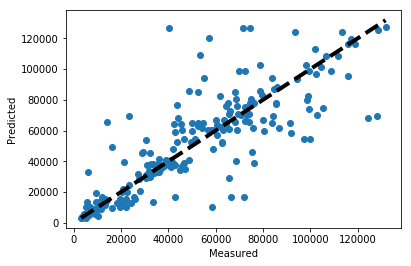

In [206]:
fig, ax = plt.subplots()
ax.scatter(test_Y, predicted)
ax.plot([test_Y.min(), test_Y.max()], [test_Y.min(), test_Y.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

In [207]:
# save the model to disk
modelfile = 'final.sav'
pickle.dump(trees, open(modelfile, 'wb'))
scaler_filename = "scaler.save"
joblib.dump(min_max_scaler, scaler_filename) 


['scaler.save']

In [208]:
trees.predict(x)

array([11253])

In [209]:
import json
with open('/Users/megha/parallel/mnt/project/progress/confex.json') as f:
    data = json.load(f)

cb_buffer_size = data["mpi"]["cb_buffer_size"]
stripe_size = data["lfs"]["setstripe"]["size"]
stripe_count = data["lfs"]["setstripe"]["count"]

col_names =  ['cb1', 'cb2', 'cb3']
cb_df  = pd.DataFrame(columns = col_names)
cb_df.loc[len(cb_df)] = [stripe_size, stripe_count, cb_buffer_size]


scaler_filename = "scaler.save"
scaler = joblib.load(scaler_filename) 
norm_df = scaler.transform( cb_df )
temp = pd.DataFrame(norm_df)




col_names =  ['0','1', '2','3','4','5']
my_df = pd.DataFrame(columns=col_names)
my_df.loc[len(my_df)] = [100,100,100,2,2,4]
x = pd.concat([my_df,temp], axis=1)


print(trees.predict(x))

[11253]


In [203]:
print(predicted)

[ 37290  34176  70599  40807 102383  98905  61563  48048  76273  13799
  36561  21999  36661  15355 126754  10075  35316   3214  40703   7459
  52230 116405   4813  64478  45698  60155  20216  13997  10539  36565
   3729  74606  10355  60632  66925  60338  36932  61265  38008  63316
   8895  19587  82576  32853  13427   5483  15144  84920   4638  80510
  76273  59813  52230  54230  38043  65226  41777  15383  75338  62740
  98905  29095   3214  88440  37251   8767  63945 116405  36810  53882
  38661  16754  85905   9824  65184  64698  96665  54164 109116 102820
  77741  32483  16641 126754  28401   8247  35766  64698  11002  64478
  66299  34999  39243  65226  58757  16641  31732  10075  31101  35006
   4108  57004  69860  93967  77741 119319  62348   5462  24675  36810
 123988  95614  12929  33770  61563  77082  65226  70193  60076  87144
 101208  64841  30988  35796  76675  46231   4638  66925  72923  52583
  33203 127542  40398  29588 113338  36811 123988  36962  59801  33203
  9899

In [210]:
x


,0,1,2,3,4,5,0,1,2
0,100,100,100,2,2,4,0.000821,0.008247,0.443572


In [211]:
test_X.head(1)

,0,1,2,3,4,5,0,1,2
11,50,50,50,2,2,2,0.000438,0.018557,0.615309


In [214]:
trees.predict(test_X.head(1))

array([37290])